# Visualizations for oral presentation

In [1]:
using Revise
using ProgressMeter
using LinearAlgebra
using ColorSchemes
using JLD
using MAT
using Plots
pyplot()
default(grid=false, label="", margin=10Plots.pt)

include("../algorithms/VMP-estimator-NARMAX.jl");
include("../algorithms/RLS-estimator-NARMAX.jl");
include("util.jl");

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /home/wmkouw/.julia/packages/Revise/OgnOk/src/packagedef.jl:1381


In [2]:
import Distributions: MvNormal,pdf

## Example signal realizations

In [104]:
# Load from .mat file
mat_data = matread("../datasets/data/NARMAXsignal_stde0.06_pol3_order4_N22_r100.mat");

In [105]:
# Polynomial degree
degree = Int64(mat_data["system"]["nd"]);

# Model orders
M1 = Int64(mat_data["system"]["na"])
M2 = Int64(mat_data["system"]["nb"])
M3 = Int64(mat_data["system"]["ne"])
M = 1 + M1 + M2 + M3

# Maximum delay
maxM = maximum([M1, M2, M3])

options = Dict("na" => M1, "nb" => M2, "ne" => M3, "nd" => degree, "dc" => false, "crossTerms" => true, "noiseCrossTerms" => false)
PΦ = gen_combs(options)
ϕ(x::Array{Float64,1}) = [prod(x.^PΦ[:,k]) for k = 1:size(PΦ,2)];

# Length of transient period
transient = 0

# Length of training signal
ix_trn = collect(1:1000) .+ transient

# Length of testing signal
ix_tst = collect(1:1000) .+ transient;

# Extract data sets
input_trn = mat_data["uTrain"][ix_trn]
output_trn = mat_data["yTrain"][ix_trn]
T_trn = length(input_trn)

input_tst = mat_data["uTest"][ix_tst]
output_tst = mat_data["yTest"][ix_tst]
T_tst = length(input_tst)

# Coefficients
θ_true = mat_data["system"]["theta"][:]
N = length(θ_true)

# Noise precision
τ_true = inv(mat_data["options"]["stde"]^2)

277.77777777777777

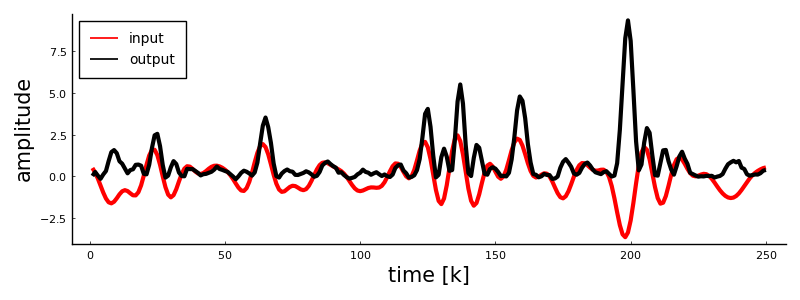

In [106]:
# Visualize signal
zoom_t = 1:250
p101 = plot(zoom_t, input_trn[zoom_t], color="red", label="input", xlabel="time [k]", ylabel="amplitude", size=(800,300), linewidth=3)
plot!(zoom_t, output_trn[zoom_t], color="black", label="output", linewidth=3, legendfontsize=10, legend=:topleft, labelfontsize=15)

In [107]:
savefig("figures/example-signal-realization.png")

## Animated simulation

### Model

In [108]:
graph = FactorGraph()

# Observed variables
@RV u_kmin1; placeholder(u_kmin1, :u_kmin1, dims=(M1,))
@RV y_kmin1; placeholder(y_kmin1, :y_kmin1, dims=(M2,))
@RV e_kmin1; placeholder(e_kmin1, :e_kmin1, dims=(M3,))
@RV u_k; placeholder(u_k, :u_k)

# Time-invariant parameters
@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(N,)), placeholder(:w_θ, dims=(N, N)))

# Likelihood
@RV y_k ~ NAutoRegressiveMovingAverageX(θ, u_k, u_kmin1, y_kmin1, e_kmin1, τ, ϕ=ϕ)
placeholder(y_k, :y_k)

# ForneyLab.draw(graph)

# Compile message passing procedure
q = PosteriorFactorization(θ, τ, ids=[:θ :τ])
algorithm = messagePassingAlgorithm([θ; τ], q, free_energy=true)
source_code = algorithmSourceCode(algorithm, free_energy=true)
eval(Meta.parse(source_code));

### Inference

In [109]:
# Initialize priors
θ_0 = (zeros(N), Matrix{Float64}(I,N,N))
τ_0 = (τ_true, 1)

# Zero-padding of signals
input_trn = [zeros(maxM,); input_trn]
input_tst = [zeros(maxM,); input_tst]
output_trn = [zeros(maxM,); output_trn]
output_tst = [zeros(maxM,); output_tst]

T_trn += maxM
T_tst += maxM

"Inference execution"

# Number of VMP iterations
num_iters = 10;

# Initialize marginals
marginals = Dict(:θ => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=θ_0[1], w=θ_0[2]),
                 :τ => ProbabilityDistribution(Univariate, Gamma, a=τ_0[1], b=τ_0[2]))

# Preallocate free energy array
Fq = zeros(T_trn-maxM, num_iters)

# Preallocate parameter arrays
params_θ = (zeros(T_trn-maxM,N), zeros(T_trn-maxM,N,N))
params_τ = (zeros(T_trn,1), zeros(T_trn,1))

# Initialize recursive parameters
θ_k = θ_0
τ_k = τ_0

# Preallocate prediction arrays
predictions_FEM = (zeros(T_trn,), zeros(T_trn,))
errors = zeros(T_trn,)

@showprogress for (ii,k) in enumerate(maxM+1:T_trn)

    # Update history vectors
    u_kmin1 = input_trn[k-1:-1:k-M1]
    y_kmin1 = output_trn[k-1:-1:k-M2]
    e_kmin1 = errors[k-1:-1:k-M3]

    ϕx = ϕ([input_trn[k]; u_kmin1; y_kmin1; e_kmin1])
    predictions_FEM[1][k] = θ_k[1]'*ϕx
    predictions_FEM[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1]/τ_k[2])

    # Compute prediction error
    errors[k] = output_trn[k] - predictions_FEM[1][k]

    # Set data 
    data = Dict(:y_k => output_trn[k],
                :u_k => input_trn[k],
                :u_kmin1 => u_kmin1,
                :y_kmin1 => y_kmin1,
                :e_kmin1 => e_kmin1,
                :m_θ => θ_k[1],
                :w_θ => θ_k[2],
                :a_τ => τ_k[1],
                :b_τ => τ_k[2])

    # Iterate updates
    for n = 1:num_iters

        # Compute free energy
        Fq[ii,n] = freeEnergy(data,marginals)

        # Update parameters
        stepθ!(data, marginals)
        stepτ!(data, marginals)

    end 

    # Update params
    θ_k = (unsafeMean(marginals[:θ]), unsafePrecision(marginals[:θ]))
    τ_k = (marginals[:τ].params[:a], marginals[:τ].params[:b])

    # Store params
    params_θ[1][ii,:] = θ_k[1]
    params_θ[2][ii,:,:] = θ_k[2]
    params_τ[1][ii] = τ_k[1]
    params_τ[2][ii] = τ_k[2]

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


### Simulation error

In [134]:
function sim_FEM(μ_θ, Λ_θ, input_tst)
    
    # Allocate
    simulations_FEM = (zeros(T_tst,), zeros(T_tst,))

    for k in maxM+1:T_tst

        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = simulations_FEM[1][k-1:-1:k-M2]
        e_kmin1 = zeros(M3,)

        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        simulations_FEM[1][k] = μ_θ'*ϕx
        simulations_FEM[2][k] = ϕx'*inv(Λ_θ)*ϕx + inv(τ_k[1] / τ_k[2])

    end

    # Compute root mean squared error
    RMS_sim_FEM = sqrt(mean((simulations_FEM[1][maxM+1:end] - output_tst[maxM+1:end]).^2))
    
    return simulations_FEM, RMS_sim_FEM
end
sims, rms_sim = sim_FEM(params_θ[1][end,:], params_θ[2][end,:,:], input_tst)

sim_FEM (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/vb-narmax/ACC2022-vmpNARMAX/experiments/figures/sim_anim.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/ldLtW/src/animation.jl:104


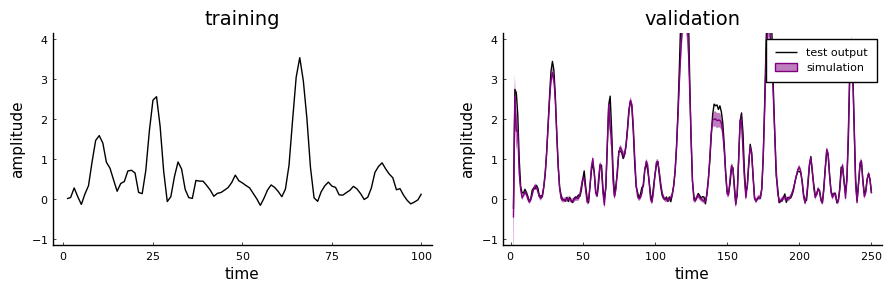

Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/vb-narmax/ACC2022-vmpNARMAX/experiments/figures/sim_anim.gif")
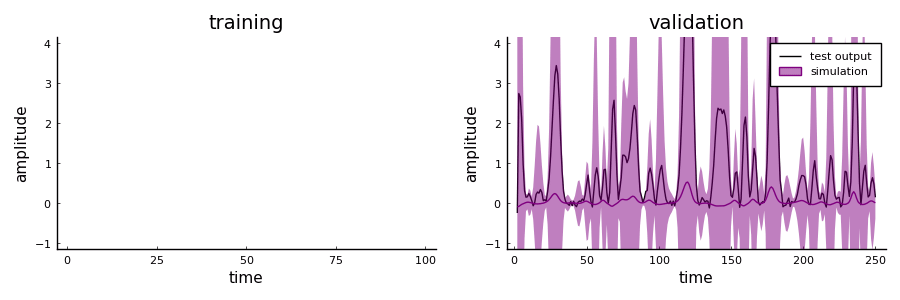

In [143]:
zoom_t = maxM+1:250

anim = @animate for t = 1:100
    p201 = plot(output_trn[1:t], color="black", xlabel="time", ylabel="amplitude", title="training", xlims=[0, 100], ylims=[-1., 4.])

    sims, rms_sim = sim_FEM(params_θ[1][t,:], params_θ[2][t,:,:], input_tst)
    
    p210 = plot(zoom_t, output_tst[zoom_t], color="black", linewidth=1, label="test output", xlabel="time", ylabel="amplitude", size=(600,220), ylims=[-1, 4.])
    plot!(zoom_t, sims[1][zoom_t], ribbon=sqrt.(sims[2][zoom_t]), color="purple", label="simulation", title="validation")

    p222 = plot(p201, p210, layout=(1,2), size=(900,300))
end
gif(anim, "figures/sim_anim.gif", fps=10)

## Evolution of coefficient posterior

In [71]:
# Load from .mat file
mat_data = matread("../datasets/data/NARMAXsignal_stde0.01_pol1_order3_N3_r1.mat");

In [72]:
# Polynomial degree
degree = Int64(mat_data["system"]["nd"]);

# Model orders
M1 = Int64(mat_data["system"]["na"])
M2 = Int64(mat_data["system"]["nb"])
M3 = Int64(mat_data["system"]["ne"])
M = 1 + M1 + M2 + M3

# Maximum delay
maxM = maximum([M1, M2, M3])

options = Dict("na" => M1, "nb" => M2, "ne" => M3, "nd" => degree, "dc" => false, "crossTerms" => true, "noiseCrossTerms" => false)
PΦ = gen_combs(options)
ϕ(x::Array{Float64,1}) = [prod(x.^PΦ[:,k]) for k = 1:size(PΦ,2)];

# Length of transient period
transient = 0

# Length of training signal
ix_trn = collect(1:1000) .+ transient

# Length of testing signal
ix_tst = collect(1:1000) .+ transient;

# Extract data sets
input_trn = mat_data["uTrain"][ix_trn]
output_trn = mat_data["yTrain"][ix_trn]
T_trn = length(input_trn)

input_tst = mat_data["uTest"][ix_tst]
output_tst = mat_data["yTest"][ix_tst]
T_tst = length(input_tst)

# Coefficients
θ_true = mat_data["system"]["theta"][:]
N = length(θ_true)

# Noise precision
τ_true = inv(mat_data["options"]["stde"]^2)

10000.0

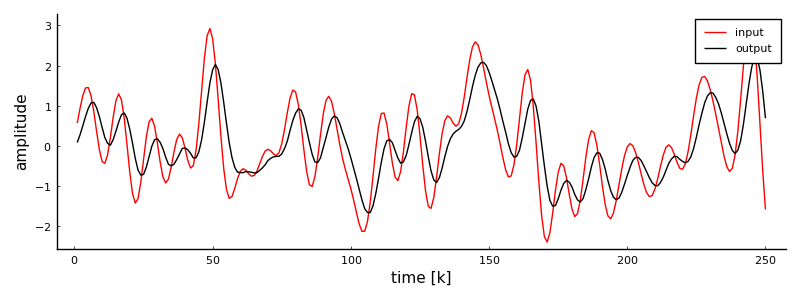

In [73]:
# Visualize signal
zoom_t = 1:250
p101 = plot(zoom_t, input_trn[zoom_t], color="red", label="input", xlabel="time [k]", ylabel="amplitude", size=(800,300))
plot!(zoom_t, output_trn[zoom_t], color="black", label="output")

### 1-step ahead prediction error

In [74]:
predictions_SYS = zeros(T_tst,)
errors = zeros(T_tst,)

for k in maxM+1:T_tst

    # Update history vectors
    u_kmin1 = input_tst[k-1:-1:k-M1]
    y_kmin1 = output_tst[k-1:-1:k-M2]
    e_kmin1 = errors[k-1:-1:k-M3]

    # Point prediction
    ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
    predictions_SYS[k] = θ_true'*ϕx

    # Update error
    errors[k] = output_tst[k] - predictions_SYS[k]

end

RMS_prd_SYS = sqrt(mean((predictions_SYS[maxM+1:end] - output_tst[maxM+1:end]).^2))

0.010012474563286619

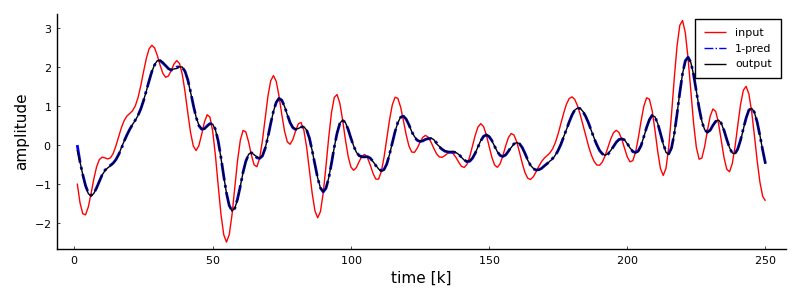

In [7]:
# Visualize signal
zoom_t = 1:250
p101 = plot(zoom_t, input_tst[zoom_t], color="red", label="input", xlabel="time [k]", ylabel="amplitude", size=(800,300))
plot!(zoom_t, predictions_SYS[zoom_t], color="blue", linewidth=2, linestyle=:dashdot,label="1-pred")
plot!(zoom_t, output_tst[zoom_t], color="black", label="output")

### Simulation error

In [8]:
simulations_SYS = zeros(T_tst,)

for k in maxM+1:T_tst

    # Update history vectors
    u_kmin1 = input_tst[k-1:-1:k-M1]
    y_kmin1 = simulations_SYS[k-1:-1:k-M2]
    e_kmin1 = zeros(M3,)

    # Posterior predictive
    ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
    simulations_SYS[k] = θ_true[:]'*ϕx

end

RMS_sim_SYS = sqrt(mean((simulations_SYS[maxM+1:end] - output_tst[maxM+1:end]).^2))

0.015717088765749936

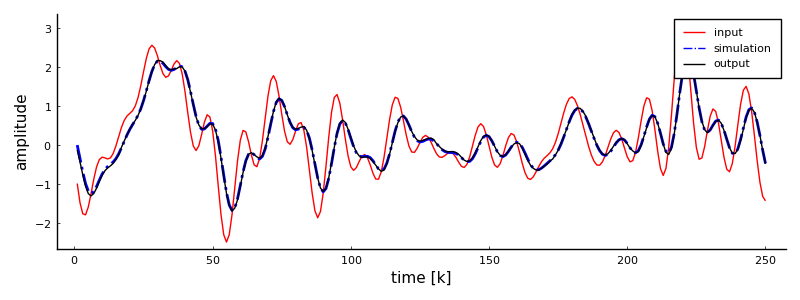

In [9]:
# Visualize signal
zoom_t = 1:250
p101 = plot(zoom_t, input_tst[zoom_t], color="red", label="input", xlabel="time [k]", ylabel="amplitude", size=(800,300))
plot!(zoom_t, simulations_SYS[zoom_t], color="blue", linewidth=2, linestyle=:dashdot, label="simulation")
plot!(zoom_t, output_tst[zoom_t], color="black", label="output")

## Estimator: Free Energy Minimisation

In [10]:
using ForneyLab
import ForneyLab: unsafeMean, unsafeCov, unsafePrecision
using NARMAX

In [11]:
graph = FactorGraph()

# Observed variables
@RV u_kmin1; placeholder(u_kmin1, :u_kmin1, dims=(M1,))
@RV y_kmin1; placeholder(y_kmin1, :y_kmin1, dims=(M2,))
@RV e_kmin1; placeholder(e_kmin1, :e_kmin1, dims=(M3,))
@RV u_k; placeholder(u_k, :u_k)

# Time-invariant parameters
@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))
@RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(N,)), placeholder(:w_θ, dims=(N, N)))

# Likelihood
@RV y_k ~ NAutoRegressiveMovingAverageX(θ, u_k, u_kmin1, y_kmin1, e_kmin1, τ, ϕ=ϕ)
placeholder(y_k, :y_k)

# ForneyLab.draw(graph)

# Compile message passing procedure
q = PosteriorFactorization(θ, τ, ids=[:θ :τ])
algorithm = messagePassingAlgorithm([θ; τ], q, free_energy=true)
source_code = algorithmSourceCode(algorithm, free_energy=true)
eval(Meta.parse(source_code));

### Estimate parameters

In [26]:
# Initialize priors
θ_0 = (zeros(N), Matrix{Float64}(I,N,N))
τ_0 = (τ_true, 1)
mτ = τ_0[1]/τ_0[2]

10000.0

In [82]:
# Zero-padding of signals
input_trn = [zeros(maxM,); input_trn]
input_tst = [zeros(maxM,); input_tst]
output_trn = [zeros(maxM,); output_trn]
output_tst = [zeros(maxM,); output_tst]

T_trn += maxM
T_tst += maxM

"Inference execution"

# Number of VMP iterations
num_iters = 10;

# Initialize marginals
marginals = Dict(:θ => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=θ_0[1], w=θ_0[2]),
                 :τ => ProbabilityDistribution(Univariate, Gamma, a=τ_0[1], b=τ_0[2]))

# Preallocate free energy array
Fq = zeros(T_trn-maxM, num_iters)

# Preallocate parameter arrays
params_θ = (zeros(T_trn-maxM,N), zeros(T_trn-maxM,N,N))
params_τ = (zeros(T_trn,1), zeros(T_trn,1))

# Initialize recursive parameters
θ_k = θ_0
τ_k = τ_0

# Preallocate prediction arrays
predictions_FEM = (zeros(T_trn,), zeros(T_trn,))
errors = zeros(T_trn,)

@showprogress for (ii,k) in enumerate(maxM+1:T_trn)

    # Update history vectors
    u_kmin1 = input_trn[k-1:-1:k-M1]
    y_kmin1 = output_trn[k-1:-1:k-M2]
    e_kmin1 = errors[k-1:-1:k-M3]

    ϕx = ϕ([input_trn[k]; u_kmin1; y_kmin1; e_kmin1])
    predictions_FEM[1][k] = θ_k[1]'*ϕx
    predictions_FEM[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1]/τ_k[2])

    # Compute prediction error
    errors[k] = output_trn[k] - predictions_FEM[1][k]

    # Set data 
    data = Dict(:y_k => output_trn[k],
                :u_k => input_trn[k],
                :u_kmin1 => u_kmin1,
                :y_kmin1 => y_kmin1,
                :e_kmin1 => e_kmin1,
                :m_θ => θ_k[1],
                :w_θ => θ_k[2],
                :a_τ => τ_k[1],
                :b_τ => τ_k[2])

    # Iterate updates
    for n = 1:num_iters

        # Compute free energy
        Fq[ii,n] = freeEnergy(data,marginals)

        # Update parameters
        stepθ!(data, marginals)
        stepτ!(data, marginals)

    end 

    # Update params
    θ_k = (unsafeMean(marginals[:θ]), unsafePrecision(marginals[:θ]))
    τ_k = (marginals[:τ].params[:a], marginals[:τ].params[:b])

    # Store params
    params_θ[1][ii,:] = θ_k[1]
    params_θ[2][ii,:,:] = θ_k[2]
    params_τ[1][ii] = τ_k[1]
    params_τ[2][ii] = τ_k[2]

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


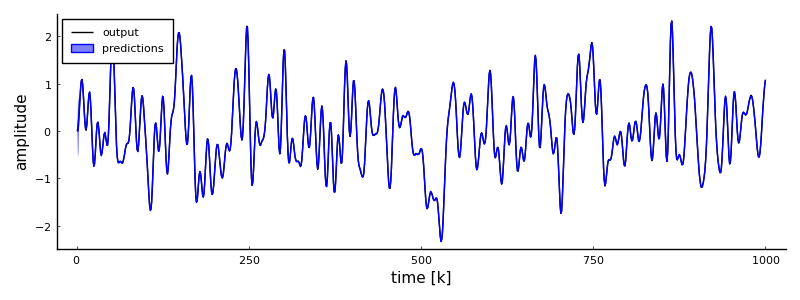

In [83]:
# Visualize signal
zoom_t = 1:1000
p101 = plot(zoom_t, output_trn[zoom_t], color="black", label="output", xlabel="time [k]", ylabel="amplitude", size=(800,300))
plot!(zoom_t, predictions_FEM[1][zoom_t], ribbon=[sqrt.(predictions_FEM[2][zoom_t]), sqrt.(predictions_FEM[2][zoom_t])], color="blue", label="predictions", legend=:topleft)

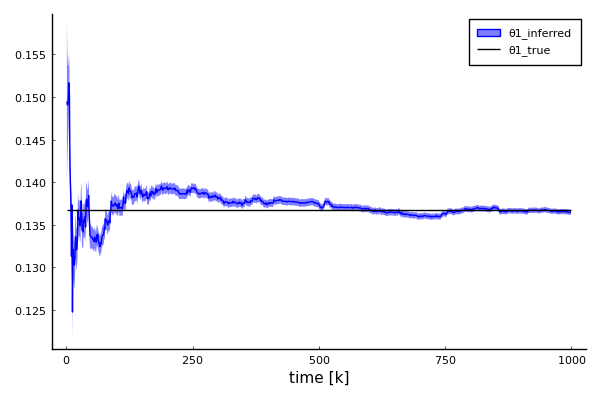

In [84]:
sdθ1 = sqrt.(inv.(params_θ[2][maxM+1:end,1,1]))
plot(params_θ[1][maxM+1:end,1], ribbon=[sdθ1 sdθ1], color="blue", xlabel="time [k]", label="θ1_inferred")
plot!(θ_true[1]*ones(T_trn-maxM-1,), color="black", label="θ1_true")

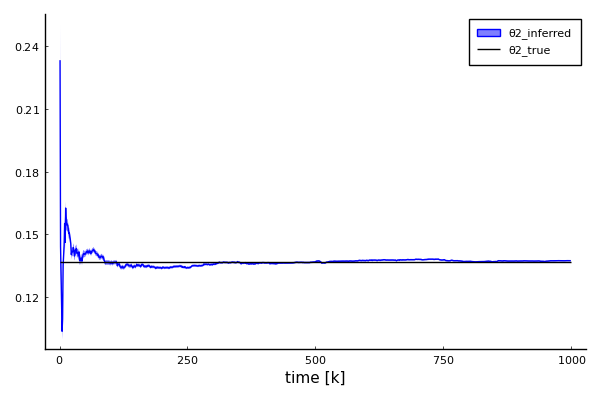

In [85]:
sdθ2 = sqrt.(inv.(params_θ[2][maxM+1:end,2,2]))
plot(params_θ[1][maxM+1:end,2], ribbon=[sdθ2 sdθ2], color="blue", xlabel="time [k]", label="θ2_inferred")
plot!(θ_true[2]*ones(T_trn-maxM-1,), color="black", label="θ2_true")

┌ Info: Saved animation to 
│   fn = /home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/vb-narmax/ACC2022-vmpNARMAX/experiments/figures/coeffpost.gif
└ @ Plots /home/wmkouw/.julia/packages/Plots/ldLtW/src/animation.jl:104


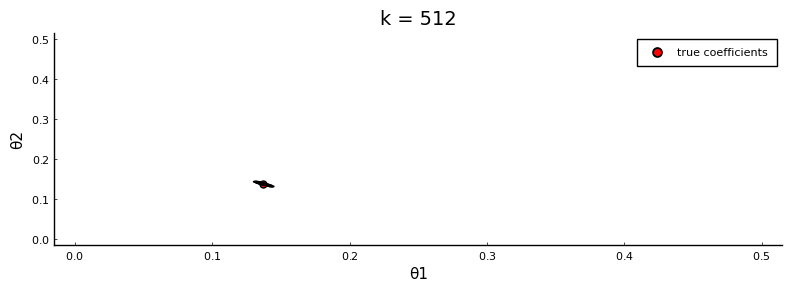

Plots.AnimatedGif("/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/tue/vb-narmax/ACC2022-vmpNARMAX/experiments/figures/coeffpost.gif")
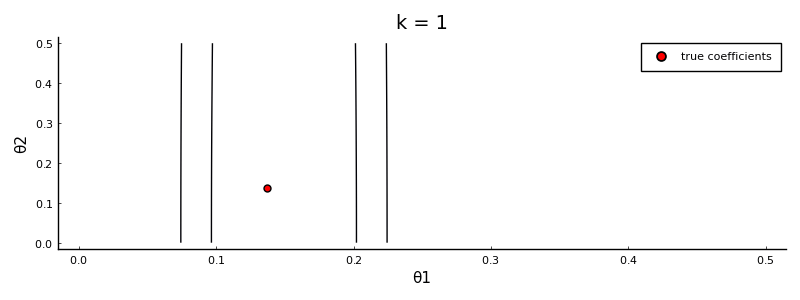

In [103]:
rθ1 = 0.0:0.001:0.5
rθ2 = 0.0:0.001:0.5

anim = @animate for n = collect(2 .^(0:9))
    scatter([θ_true[1]], [θ_true[2]], xlabel="θ1", ylabel="θ2", color="red", markersize=5, size=(800,300), label="true coefficients", title="k = "*string(n))
    contour!(rθ1, rθ2, (x,y) -> pdf(MvNormal(params_θ[1][n,1:2], inv(params_θ[2][n,1:2,1:2])), [x,y]), linewidth=1, levels=[0.001, 0.1, 10.], cbar=:none)
end
gif(anim, "figures/coeffpost.gif", fps=2)

In [ ]:
# rθ1 = 0.0:0.001:0.5
# rθ2 = 0.0:0.001:0.5

# anim = @animate for n = 0:1
#     plotn = scatter([θ_true[1]], [θ_true[2]], xlabel="θ1", ylabel="θ2", color="red", markersize=5, size=(900,300))

#     if n == 0
#         contour!(rθ1, rθ2, (x,y) -> pdf(MvNormal(θ_0[1][1:2], θ_0[2][1:2,1:2]), [x,y]), linewidth=3, levels=[0.1, 10.])
#     else
#         contour!(rθ1, rθ2, (x,y) -> pdf(MvNormal(params_θ[1][n,1:2], params_θ[2][n,1:2,1:2]), [x,y]), linewidth=3, levels=[0.1, 10.])
#     end
# end
# # gif(anim, "figures/coeffpost_frame"*string(n)*".gif")

In [ ]:
rθ1 = 0.0:0.001:0.5
rθ2 = 0.0:0.001:0.5

anim = @animate for n = 0:(T_trn-maxM)
    
    scatter([θ_true[1]], [θ_true[2]], xlabel="θ1", ylabel="θ2", color="black", markersize=5, size=(900,300))
    
    if n == 0
        contour!(rθ1, rθ2, (x,y) -> pdf(MvNormal(θ_0[1][1:2], θ_0[2][1:2,1:2]), [x,y]), linewidth=3, levels=[0.1, 10.], c=:vik)
    else
        contour!(rθ1, rθ2, (x,y) -> pdf(MvNormal(params_θ[1][n,1:2], inv(params_θ[2][n,1:2,1:2])), [x,y]), linewidth=3, levels=[0.1, 10.], c=:vik)
    end
end
gif(anim, "figures/coefficient_posterior.gif", fps=10)